In [1]:
import sys
import pyro
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
sys.path.append('../')

/Users/matthias.christenson/anaconda3/envs/ccmf/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from paccman.circuit import CircuitModel

In [3]:
circuit = CircuitModel()

In [4]:
circuit.add_neuron('a', vary=False)
circuit.add_neuron('b', vary=True)
circuit.add_neuron('c', nonlin=torch.tanh, offset=None)
circuit.add_neuron('d', nonlin=torch.tanh, offset=None)

In [5]:
a = np.random.normal(0, 0.1, 100)[:, None]
b = np.random.normal(0, 0.1, 100)[:, None]
b_data = b + np.random.normal(0, np.ones(10) * 0.01)[None, :]
c = np.tanh(0.2 * a + 0.8 * b)  # TODO normalize before
c_data = c + np.random.normal(0, np.ones(50) * 0.01)[None, :]
c_data = c_data * np.random.random(50)[None, :]
d = np.tanh(0.3 * a + 0.3 * b + 0.4 * c)
d_data = d + np.random.normal(0, np.ones(35) * 0.01)[None, :]
d_data = d_data * np.random.random(35)[None, :]

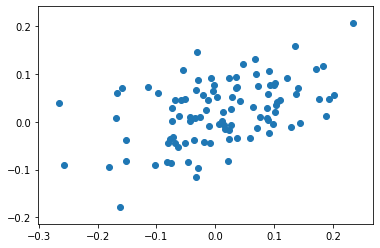

In [6]:
plt.scatter(a, d_data[:, 4])

In [7]:
circuit.add_synapse('a', 'c', sign=1.0)
circuit.add_synapse('b', 'c', sign=1.0)
circuit.add_synapse('a', 'd', sign=1.0)
circuit.add_synapse('b', 'd', sign=1.0)
circuit.add_synapse('c', 'd', sign=1.0)

In [8]:
circuit.add_data('c', c_data)
circuit.add_data('d', d_data)
circuit.add_data('a', a, scale=0)
circuit.add_data('b', b_data, scale=0.1)

In [9]:
from paccman.map import MAPEstimator

In [10]:
est = MAPEstimator(verbose=True)

In [11]:
est.fit(circuit)

100%|██████████| 1000/1000 [00:08<00:00, 119.21it/s]


MAPEstimator(learning_rate=0.01, max_iter=1000, verbose=True)

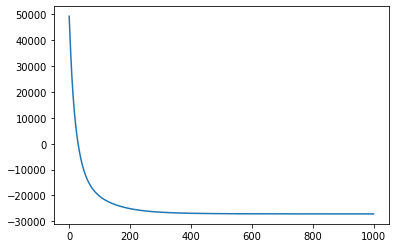

In [12]:
plt.plot(est.loss_curve_)

In [13]:
est.map_estimates_

{'b': tensor([-0.0352,  0.2681, -0.1568,  0.0913, -0.0074, -0.0995,  0.0100,  0.1481,
          0.2775,  0.0929,  0.1931,  0.1565,  0.0823, -0.0474,  0.0546, -0.0679,
         -0.0423, -0.2325,  0.2302,  0.1968,  0.2917, -0.0647, -0.1644, -0.1665,
          0.2433, -0.2435,  0.0407, -0.2759, -0.0981,  0.1198, -0.1338, -0.0581,
         -0.0328,  0.2201, -0.1269, -0.0189,  0.0318, -0.1121, -0.0412, -0.1587,
          0.0360, -0.0901,  0.1301, -0.1631,  0.0859, -0.1431,  0.0848, -0.0771,
         -0.0930, -0.0439,  0.0132,  0.0738, -0.0694, -0.0227,  0.0173,  0.1385,
         -0.1592,  0.2595,  0.1276,  0.1274, -0.0974, -0.1269,  0.1086,  0.0384,
         -0.0737,  0.0649,  0.2250, -0.1682, -0.0855,  0.1696, -0.0179,  0.0113,
          0.0098,  0.3489, -0.0370,  0.2753,  0.1562, -0.0702,  0.2009,  0.0712,
         -0.1578,  0.0897,  0.1616,  0.0766, -0.3223, -0.1234,  0.0318,  0.0163,
         -0.0928, -0.1916,  0.1432, -0.0705, -0.0098, -0.0676, -0.0835,  0.0196,
         -0.0924,  0.13

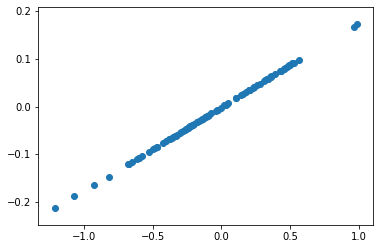

In [14]:
plt.scatter(
    np.array(est.map_estimates_['d'].detach()), 
    d
)

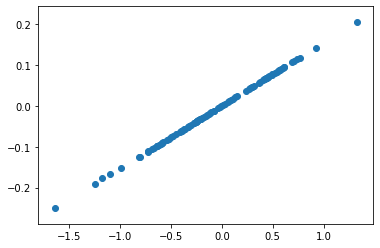

In [15]:
plt.scatter(
    np.array(est.map_estimates_['c'].detach()), 
    c
)

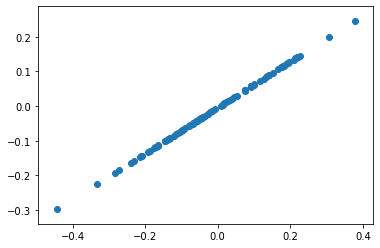

In [16]:
plt.scatter(
    np.array(est.map_estimates_['b'].detach()), 
    b
)

In [ ]:
from paccman.mcmc import MCMCSampler

In [ ]:
mcmc = MCMCSampler(warmup_steps=100)

In [ ]:
mcmc.fit(circuit)

In [ ]:
plt.errorbar(
    c, 
    mcmc.samples_['c'].mean(axis=0))

In [ ]:
ac = np.array(mcmc.samples_['a->c'])

In [ ]:
bc = np.array(mcmc.samples_['b->c'])

In [ ]:
weights = np.stack([ac, bc])
weights /= weights.sum(0, keepdims=True)

In [ ]:
plt.hist(weights[0])
plt.hist(weights[1])

In [ ]:
weights[0].mean(), weights[1].mean()

In [14]:
from pyro import distributions as dist